In [1]:
import torch
import yaml
import einops
import torchvision
import os
from tqdm import tqdm
from torch.utils.data import DataLoader
import os
import matplotlib.pyplot as plt
import numpy as np
from torchvision.transforms.functional import to_pil_image
import torch.nn.functional as F
import umap.umap_ as umap
from utils import make_coord_grid
import yaml
from datasets import make as make_dataset
from models import make as make_model
import pickle
from sklearn.manifold import TSNE


def load_config(yaml_path):
    with open(yaml_path, 'r') as f:
        return yaml.safe_load(f)


@torch.no_grad()
def evaluate_model(model, dataloader, device='cuda', res_factor = 1, lainr = True, only_one=False, sr = True):
    model.eval()
    total_loss = 0
    total_psnr = 0
    count = 0
    i = 0

    for data in tqdm(dataloader, desc='Evaluating'):
        if i > 0 and only_one:
            break

        for k, v in data.items():
            if torch.is_tensor(v):
                data[k] = v.cuda()
        gt = data.pop('gt')
        if sr:
            gt = {k: v.cuda() for k, v in gt.items()}
            gt_hr = gt.pop('hr')
            gt = gt.pop('lr')
        #print(gt.shape)

        B = gt.shape[0]
        #gt = gt[0]  # (C, H, W)

        if lainr:
            hyponet, tokens = model(data)
            coord = make_coord_grid(torch.Size([gt.shape[-1] * res_factor, gt.shape[-2]* res_factor]), (0, 1), device=gt.device)
        else:
            hyponet = model(data)
            coord = make_coord_grid(gt.shape[-2:], (0, 1), device=gt.device)

       
        #coord = make_coord_grid(torch.Size([gt.shape[-1] * res_factor, gt.shape[-2]* res_factor]), (0, 1), device=gt.device)

        coord = einops.repeat(coord, 'h w d -> b h w d', b=B)
        
        if lainr:
            pred = hyponet(coord, tokens)
            gt_hr = einops.rearrange(gt_hr, 'b c h w -> b h w c')
            if res_factor == 2:
                gt = gt_hr.permute(0, 3, 1, 2)
                gt = F.avg_pool2d(gt, kernel_size=2, stride=2)
                gt = gt.permute(0, 2, 3, 1)
            elif res_factor == 1:
                gt = einops.rearrange(gt, 'b c h w -> b h w c')
            else:
                gt = gt_hr
        else:
            pred = hyponet(coord)
            gt = einops.rearrange(gt, 'b c h w -> b h w c')
        
        
        mses = ((pred - gt)**2).view(B, -1).mean(dim=-1)
        loss = mses.mean()
        psnr = (-10 * torch.log10(mses)).mean()

        total_loss += loss.item() * B
        total_psnr += psnr.item() * B
        count += B
        i+=1

    avg_loss = total_loss / count
    avg_psnr = total_psnr / count
    print(f"Avg Loss: {avg_loss:.6f}, Avg PSNR: {avg_psnr:.2f}")
    return avg_loss, avg_psnr


@torch.no_grad()
def visualize_results(model, dataloader, device='cuda', n_samples=8, out_dir='./eval_vis', figsize=(6, 3), res_factor = 1, lainr=True, sr = True):
    os.makedirs(out_dir, exist_ok=True)
    model.eval()
    data_iter = iter(dataloader)

    for i in range(n_samples):
        try:
            data = next(data_iter)
        except StopIteration:
            break

        for k, v in data.items():
            if torch.is_tensor(v):
                data[k] = v.cuda()
        gt = data.pop('gt')
        if sr:
            gt = {k: v.cuda() for k, v in gt.items()}
            gt_hr = gt.pop('hr')
            gt_hr = gt_hr[0]
            gt = gt.pop('lr')
            print(gt_hr.shape)
            #gt = gt_lr
        B = gt.shape[0]
        gt = gt[0]  # (C, H, W)
        

        
        if lainr:
            hyponet, tokens = model(data)
        else:
            hyponet = model(data)
            
        #print(coord)
        #coord = make_coord_grid(gt.shape[-2:], (-1, 1), device=gt.device)
        coord = make_coord_grid(torch.Size([gt.shape[-1] * res_factor, gt.shape[-2]* res_factor]), (0, 1), device=gt.device)
        coord = einops.repeat(coord, 'h w d -> b h w d', b=B)
        
        if lainr:
            pred = hyponet(coord, tokens)[0].clamp(0, 1)  # (H, W, C)
        else:
            pred = hyponet(coord)[0].clamp(0, 1)  # (H, W, C)

        pred = einops.rearrange(pred, 'h w c -> c h w')  # (C, H, W)

        # Convert tensors to NumPy for plotting
        gt_img = to_pil_image(gt.cpu())

        pred_img = to_pil_image(pred.cpu())

        # Plot with standardized figure size

        if sr:
            gt_hr_img = to_pil_image(gt_hr.cpu())
            if res_factor in [1, 4]:
                fig, axs = plt.subplots(1, 4, figsize=figsize)
            else:
                fig, axs = plt.subplots(1, 3, figsize=figsize)
            
            axs[0].imshow(gt_img)
            axs[0].set_title('Ground Truth')
            axs[0].axis('off')
    
            axs[1].imshow(gt_hr_img)
            axs[1].set_title('Ground Truth HR')
            axs[1].axis('off')
    
            axs[2].imshow(pred_img)
            axs[2].set_title('Prediction')
            axs[2].axis('off')

            if res_factor == 1:
                print((gt-pred).shape)
                dif = to_pil_image(torch.mean(torch.abs(gt - pred), dim = 0).cpu())
                axs[3].imshow(dif)
                axs[3].set_title('Dif')
                axs[3].axis('off')
            elif res_factor == 4:
                dif = to_pil_image(torch.mean(torch.abs(gt_hr - pred), dim = 0).cpu())
                axs[3].imshow(dif)
                axs[3].set_title('Dif')
                axs[3].axis('off')
                
    
            plt.tight_layout()
            plt.savefig(os.path.join(out_dir, f'{i:03d}.png'))
            plt.show()
            plt.close()
        else:
            fig, axs = plt.subplots(1, 2, figsize=figsize)
            axs[0].imshow(gt_img)
            axs[0].set_title('Ground Truth')
            axs[0].axis('off')
    
            axs[1].imshow(pred_img)
            axs[1].set_title('Prediction')
            axs[1].axis('off')
    
            plt.tight_layout()
            plt.savefig(os.path.join(out_dir, f'{i:03d}.png'))
            plt.show()
            plt.close()

        print(f"Saved image {i} to {out_dir}/")

def set_lp_idxs(seq_len, num_lp, type = 'equidistant', n = 1):
        total_len = seq_len + num_lp
        if type == 'equidistant':
            insert_idxs = torch.linspace(0, total_len - 1, steps=num_lp).long()
        elif type == 'middle':
            insert_idxs = (np.array(range(num_lp))+(seq_len//2)).tolist()
            insert_idxs = torch.tensor(insert_idxs)
        elif type == 'n_group':
            if num_lp%n != 0:
                raise Exception("n must divide number of lps evenly")
            insert_idxs = []
            pre_idxs = torch.linspace(0, total_len - n, steps=num_lp//n).long()
            for idx in pre_idxs:
                insert_idxs.extend([idx+i for i in range(n)])
        return insert_idxs


In [322]:
# Load YAML config
#cfg_string = 'imgrec_cifar10_mamba_lainr_fourier_long_constant'
#cfg_string = 'imgrec_celeba_transinr'
cfg_string = 'imgrec_celeba_mamba_lainr_fourier_sr_noperturbation'
cfg_dataset_string = 'imgrec_cifar10_mamba_lainr_fourier_sr2'
cfg = load_config(f'./cfgs/sr_ablation/{cfg_string}.yaml')
cfg_dataset = load_config(f'./cfgs/poster_graphs/sr_comparison/{cfg_dataset_string}.yaml')
print(cfg)
cfg['test_dataset'] = cfg_dataset['test_dataset']
#cfg_dt['model']['name'] = cfg['model']['name']+'_print_dt'
#cfg_dt['model']['args']['mamba_encoder']['name']= 'mamba_encoder_dt'

{'trainer': {'name': 'imgrec_trainer_lainr_sr', 'args': {'p': 0.0}}, 'train_dataset': {'name': 'sr_dataset', 'args': {'imageset': {'name': 'celebahq_sr', 'args': {'root_path': '/home/idies/.cache/kagglehub/datasets/lamsimon/celebahq/versions/1/', 'split': 'train'}}, 'resize_1': 256, 'resize_2': 64}, 'loader': {'batch_size': 16, 'num_workers': 8}}, 'test_dataset': {'name': 'sr_dataset', 'args': {'imageset': {'name': 'celebahq_sr', 'args': {'root_path': '/home/idies/.cache/kagglehub/datasets/lamsimon/celebahq/versions/1/', 'split': 'test'}}, 'resize_1': 256, 'resize_2': 64}, 'loader': {'batch_size': 16, 'num_workers': 8}}, 'model': {'name': 'mamba_lainr_inr_sr', 'args': {'tokenizer': {'name': 'mamba_patch_tokenizer', 'args': {'input_size': 64, 'patch_size': 4, 'dim': 256, 'pos_emb': 'fourier'}}, 'hyponet': {'name': 'lainr_mlp_bias', 'args': {'feature_dim': 256, 'input_dim': 2, 'output_dim': 3, 'sigma_q': 16, 'sigma_ls': [128, 32], 'n_patches': 256}}, 'mamba_encoder': {'name': 'mamba_enco

In [323]:
# Create model and dataset
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
test_dataset = make_dataset(cfg['test_dataset'])
train_dataset = make_dataset(cfg['train_dataset'])

test_loader = DataLoader(
    test_dataset,
    batch_size=cfg['test_dataset']['loader']['batch_size'],
    num_workers=cfg['test_dataset']['loader']['num_workers'],
    shuffle=False,
    pin_memory=True
)

train_loader = DataLoader(
    train_dataset,
    batch_size=cfg['train_dataset']['loader']['batch_size'],
    num_workers=cfg['train_dataset']['loader']['num_workers'],
    shuffle=False,
    pin_memory=True
)



In [324]:
#cfg['model']['args']['tokenizer']['name']= 'mamba_patch_tokenizer'
#cfg_dt['model']['args']['tokenizer']['name']= 'mamba_patch_tokenizer'

model = make_model(cfg['model']).to(device)
#model_dt = make_model(cfg_dt['model']).to(device)

In [325]:
# Load checkpoint
#cfg_string_train = 'imgrec_cifar10_mamba_composers_fourier_long'
cfg_string_train = cfg_string
cfg_string_train_full = f'{cfg_string_train}'
cfg_train = load_config(f'./cfgs/sr_ablation/{cfg_string_train_full}.yaml')
ckpt_path = f'./save/{cfg_string_train}/epoch-last.pth'
checkpoint = torch.load(ckpt_path, weights_only=False)
print(checkpoint['model'].keys())
#model = torch.load(ckpt_path)['model']
model.load_state_dict(checkpoint['model']['sd'])
#model_dt.load_state_dict(checkpoint['model']['sd'])

dict_keys(['name', 'args', 'sd'])


<All keys matched successfully>

In [ ]:
evaluate_model(model_dt, train_loader, device, only_one=True, sr = False, lainr = False)

In [315]:
evaluate_model(model, test_loader, device, res_factor = 1, only_one=False, lainr=True, sr = True)

Evaluating: 100%|██████████| 63/63 [00:02<00:00, 23.31it/s]

Avg Loss: 0.000010, Avg PSNR: 50.74


(9.713083549286238e-06, 50.7420807800293)

In [230]:
evaluate_model(model, test_loader, device, res_factor = 2, only_one=False, lainr=True, sr = True)

Evaluating: 100%|██████████| 63/63 [00:02<00:00, 29.52it/s]

Avg Loss: 0.010279, Avg PSNR: 19.91


(0.01027917418628931, 19.912267715454103)

In [231]:
evaluate_model(model, test_loader, device, res_factor = 4, only_one=False, lainr=True, sr = True)

Evaluating: 100%|██████████| 63/63 [00:04<00:00, 13.49it/s]

Avg Loss: 0.012090, Avg PSNR: 19.22


(0.012089509353041648, 19.215975402832033)

torch.Size([3, 256, 256])


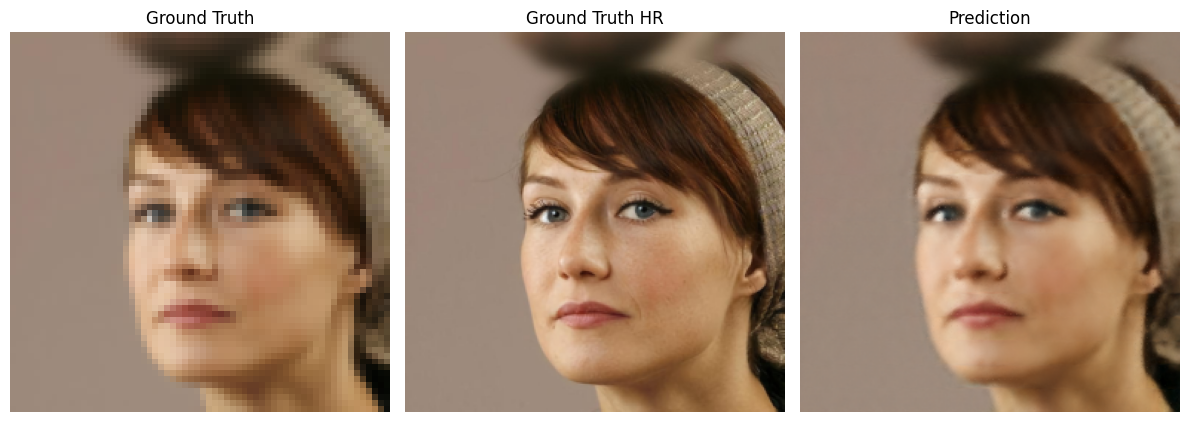

Saved image 0 to ./eval_vis/


In [328]:
visualize_results(model, test_loader, device, n_samples=1, out_dir='./eval_vis', figsize=(12, 6), res_factor = 8, lainr=True, sr = True)

In [111]:
with open('./features_dts.pkl', 'rb') as file:
        features, dts, dts_lr = pickle.load(file)

features = torch.stack(features)
dts = torch.stack(dts)
dts_lr = torch.stack(dts_lr)

print(dts.shape) # Layer, FR, B, D, L
dt_f = dts[0, 0, 0] 
print(dts_lr.shape)# Layer, FR, B, D, L
print(features.shape) #Layers, B, L, D

torch.Size([6, 2, 16, 512, 512])
torch.Size([6, 2, 16, 16, 512])
torch.Size([6, 16, 512, 256])


In [112]:
feature = features[0, 0]
total_len = feature.shape[0]
lp = model_dt.num_lp
print(lp)
if 'n_group' in cfg_train['model']['args'].keys():
    n = cfg_train['model']['args']['n_group']
else:
    n = 1

if 'type' in cfg_train['model']['args'].keys():
    type = cfg_train['model']['args']['type']
else:
    type = 'equidistant'
    
insert_idxs = set_lp_idxs(total_len-lp, lp, type = type, n = n)
print(len(insert_idxs))
print(feature.shape)

256
256
torch.Size([512, 256])


/home/idies/workspace/Storage/tbalasoor/persistent/mambaenv/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


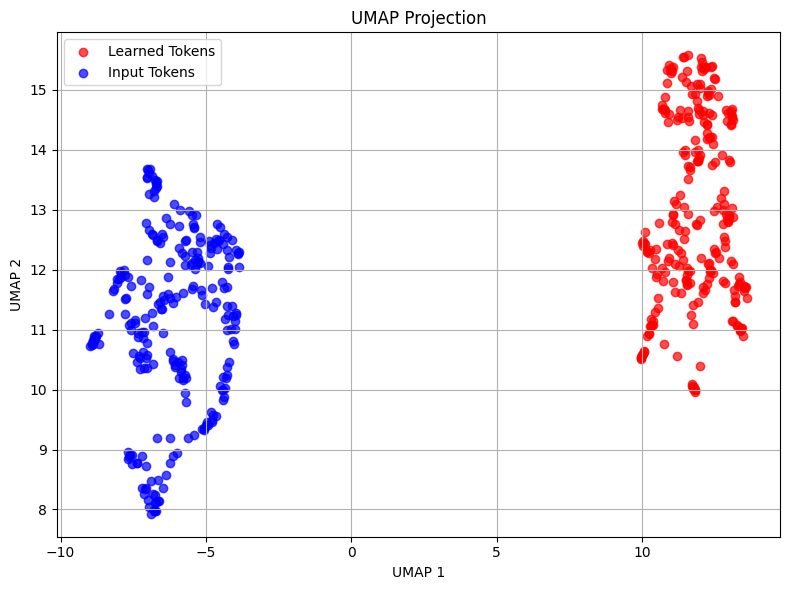

In [113]:
# Assume you already have:
# features: (L, D) torch tensor
# idxs: list or 1D tensor of M indices belonging to class 0

# Example dummy data (remove these when using real data)
# features = torch.randn(100, 64)  # L=100, D=64
# idxs = torch.randint(0, 100, (40,))  # 40 random indices as class 0

# Step 1: Create label array
L = feature.shape[0]
labels = torch.ones(L, dtype=torch.int32)
labels[insert_idxs] = 0

# Step 2: Apply UMAP
reducer = umap.UMAP(n_components=2, random_state=42)
embedding = reducer.fit_transform(feature.cpu().numpy())  # (L, 2)

# Step 3: Plot
plt.figure(figsize=(8, 6))
plt.scatter(embedding[labels == 0, 0], embedding[labels == 0, 1], c='red', label='Learned Tokens', alpha=0.7)
plt.scatter(embedding[labels == 1, 0], embedding[labels == 1, 1], c='blue', label='Input Tokens', alpha=0.7)
plt.legend()
plt.title("UMAP Projection")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.grid(True)
plt.tight_layout()
plt.show()

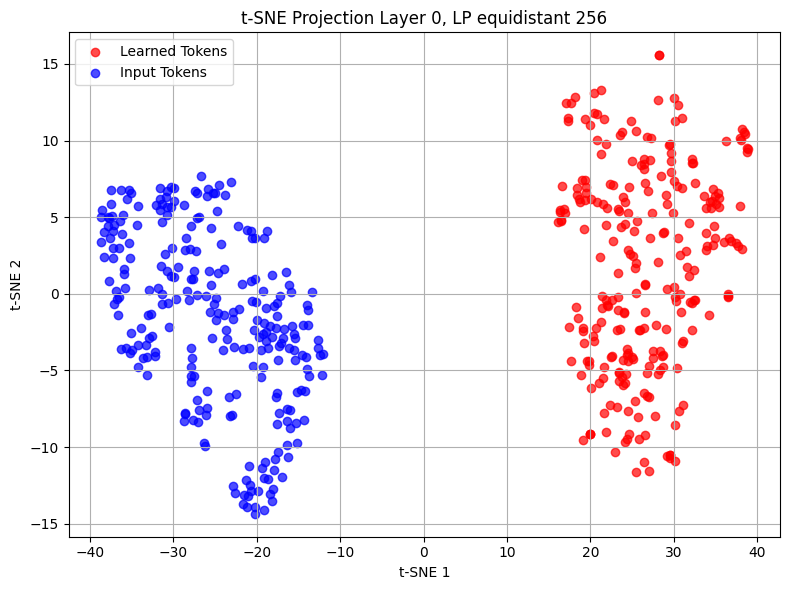

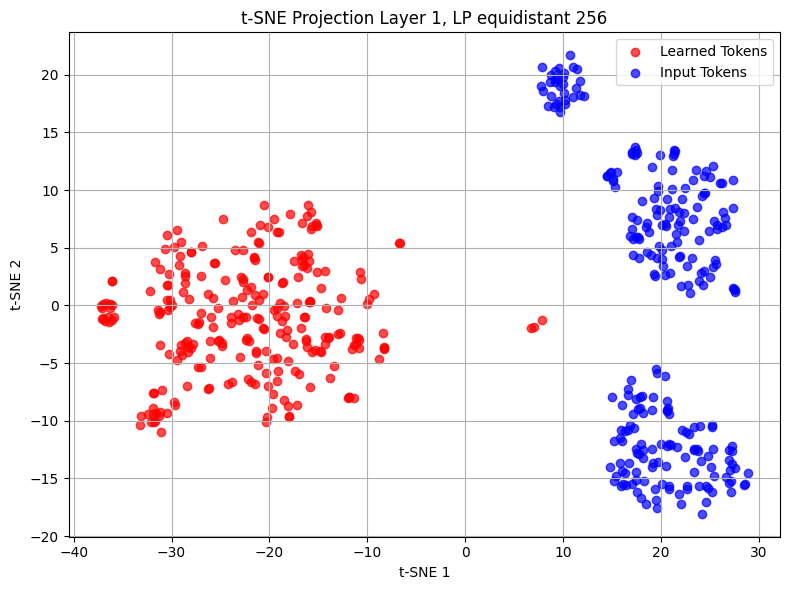

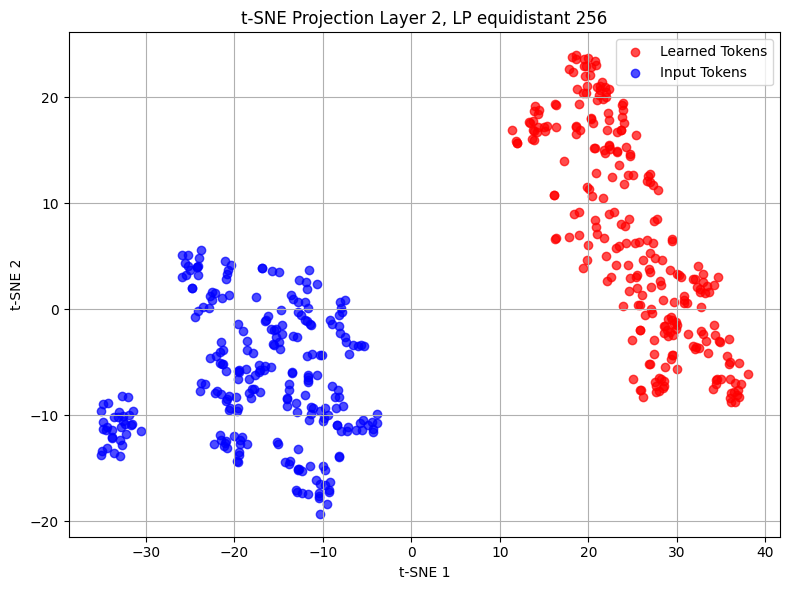

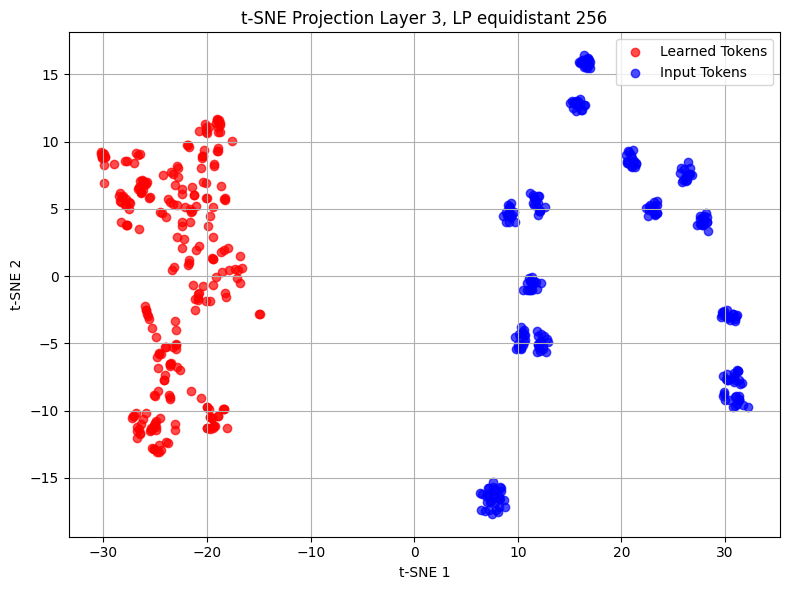

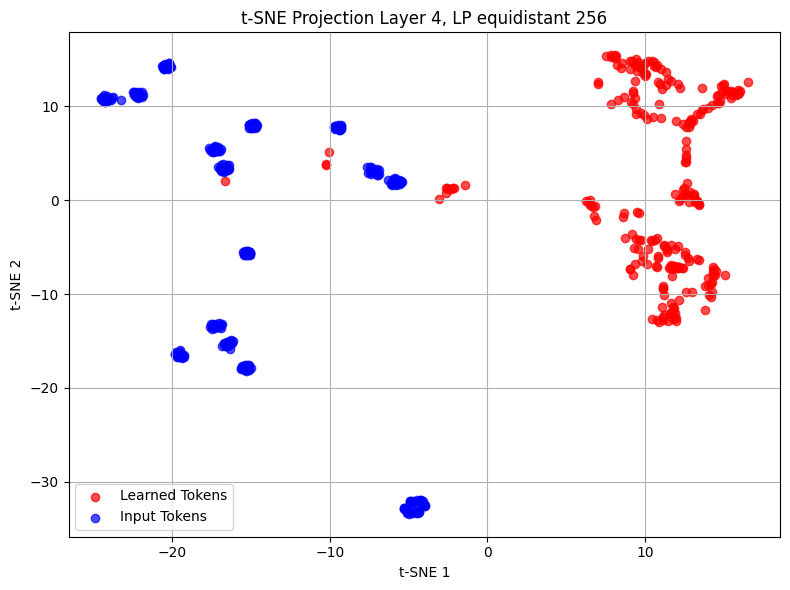

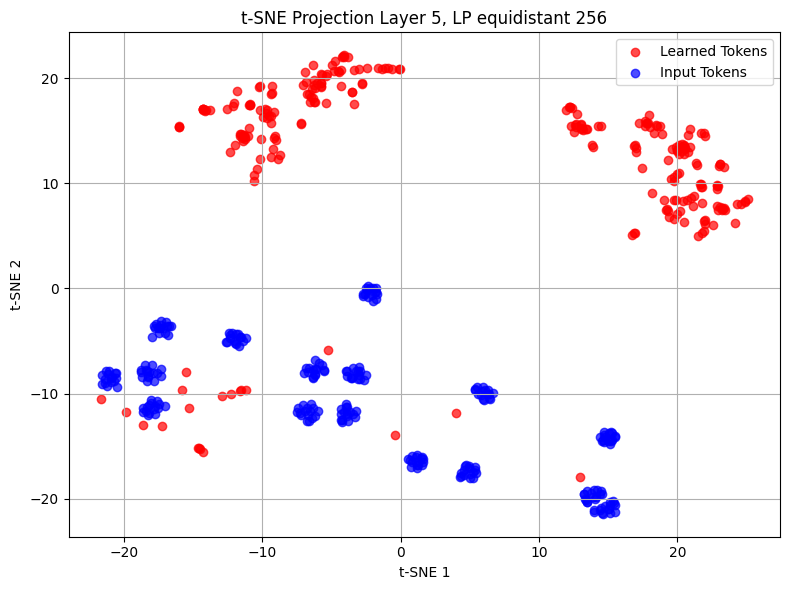

In [115]:
# Assume:
# features: (L, D) torch tensor
# idxs: list or 1D tensor of indices for class 0

# Create class labels
for i in range(6):
    feature = features[i, 0]
    L = feature.shape[0]
    labels = torch.ones(L, dtype=torch.int32)
    labels[insert_idxs] = 0
    
    # Run t-SNE
    tsne = TSNE(n_components=2, perplexity=35, random_state=42)
    embedding = tsne.fit_transform(feature.cpu().numpy())  # shape (L, 2)
    
    # Plot
    plt.figure(figsize=(8, 6))
    plt.scatter(embedding[labels == 0, 0], embedding[labels == 0, 1], c='red', label='Learned Tokens', alpha=0.7)
    plt.scatter(embedding[labels == 1, 0], embedding[labels == 1, 1], c='blue', label='Input Tokens', alpha=0.7)
    plt.legend()
    plt.title(f"t-SNE Projection Layer {i}, LP equidistant 256")
    plt.xlabel("t-SNE 1")
    plt.ylabel("t-SNE 2")
    plt.grid(True)
    plt.tight_layout()
    #plt.savefig(f'./figs/tsne_layer{i}_middle_64.png')
    plt.show()

torch.Size([16, 512])
Mean values of dt for LP is -0.02724863775074482
Mean values of dt for input tokens is -0.14627677202224731


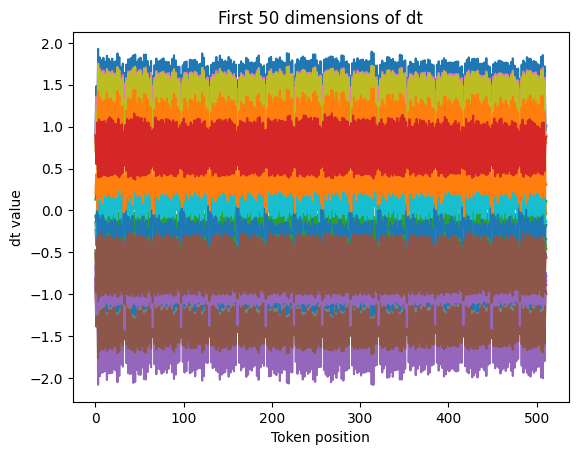

In [116]:
import matplotlib.pyplot as plt

dt_f = dts_lr[0, 0, 0]
dt_f = dt_f.detach().cpu()
dt = dt_f[:L-1] # shape (50, L)
print(dt.shape)
x = insert_idxs
mask = torch.ones(L, dtype=bool)
mask[x] = False   
print(f"Mean values of dt for LP is {torch.mean(dt[:, x])}")
print(f"Mean values of dt for input tokens is {torch.mean(dt[:, mask])}")

plt.plot(dt.T)  # Transpose to (L, 50)
plt.xlabel('Token position')
plt.ylabel('dt value')
plt.title('First 50 dimensions of dt')
plt.show()


dim 137: score = 1.9856, abs_diff = 0.0312, std_dev = 0.0157
dim 252: score = 1.9850, abs_diff = 0.2449, std_dev = 0.1234
dim 213: score = 1.9849, abs_diff = 0.2445, std_dev = 0.1232
torch.Size([256])


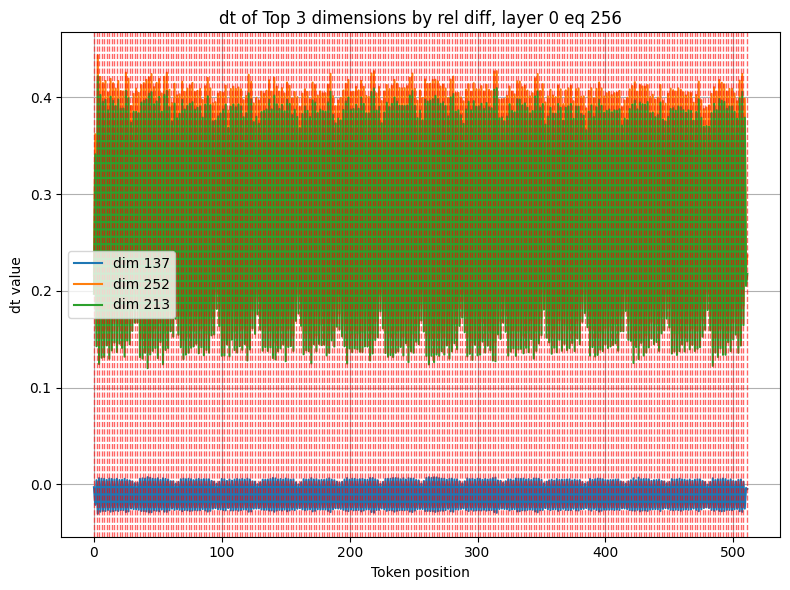

dim 275: score = 1.9729, abs_diff = 0.5474, std_dev = 0.2775
dim 140: score = 1.9726, abs_diff = 0.2776, std_dev = 0.1407
dim 90: score = 1.9718, abs_diff = 0.3732, std_dev = 0.1892
torch.Size([256])


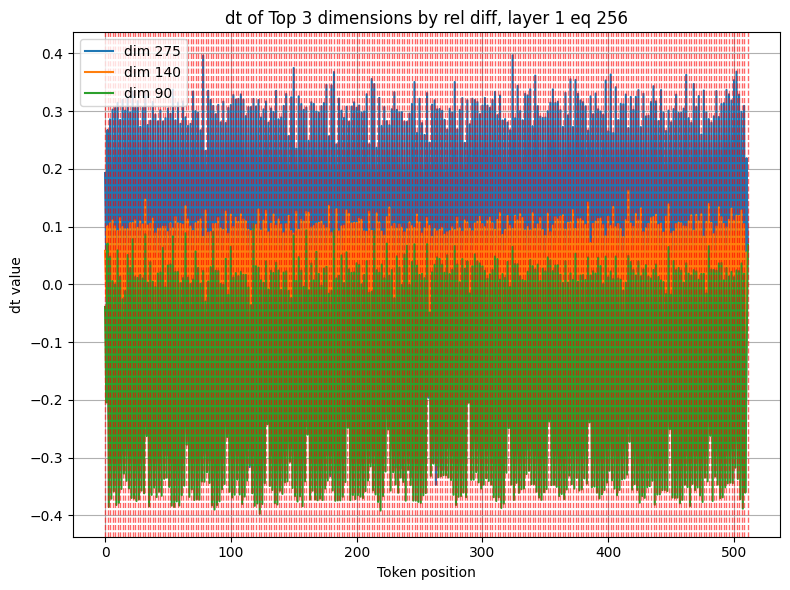

dim 501: score = 1.9688, abs_diff = 0.2789, std_dev = 0.1417
dim 295: score = 1.9671, abs_diff = 0.6391, std_dev = 0.3249
dim 217: score = 1.9663, abs_diff = 0.1482, std_dev = 0.0754
torch.Size([256])


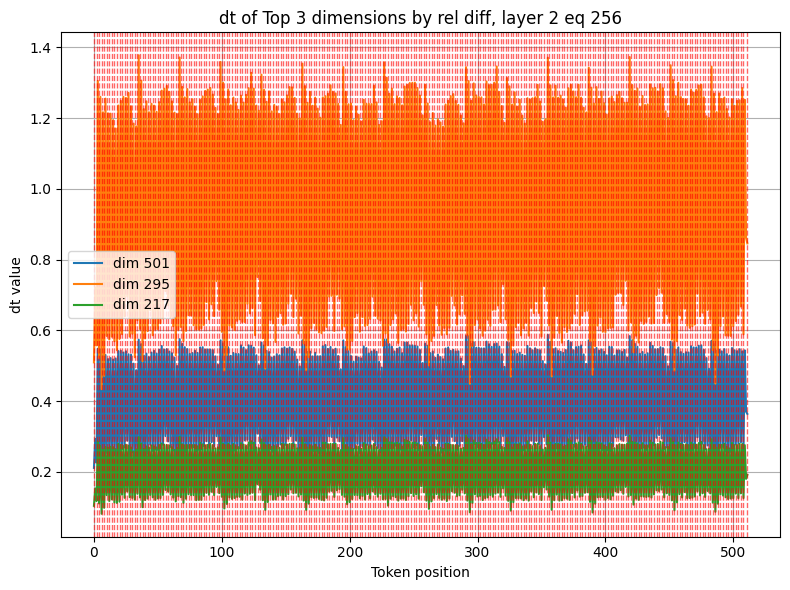

dim 480: score = 1.9643, abs_diff = 1.8524, std_dev = 0.9430
dim 452: score = 1.9636, abs_diff = 0.2612, std_dev = 0.1330
dim 484: score = 1.9621, abs_diff = 0.7121, std_dev = 0.3630
torch.Size([256])


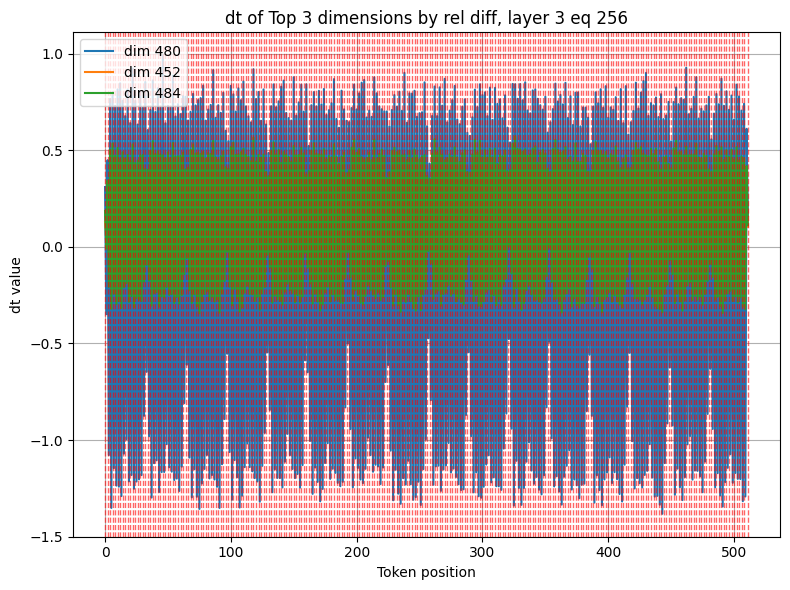

dim 67: score = 1.8498, abs_diff = 0.7675, std_dev = 0.4149
dim 13: score = 1.8242, abs_diff = 0.6779, std_dev = 0.3716
dim  1: score = 1.7966, abs_diff = 0.5085, std_dev = 0.2830
torch.Size([256])


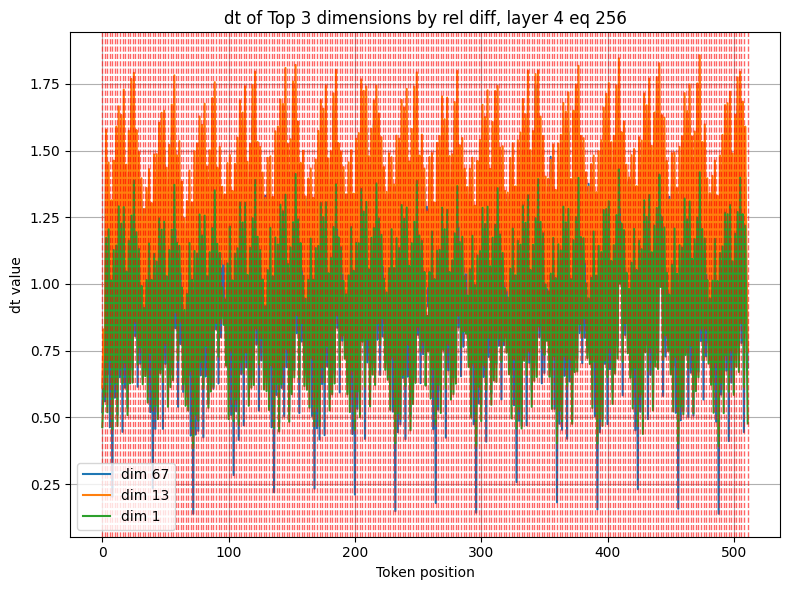

dim 485: score = 1.5603, abs_diff = 0.3870, std_dev = 0.2480
dim 244: score = 1.5365, abs_diff = 1.8776, std_dev = 1.2220
dim 421: score = 1.4680, abs_diff = 0.4438, std_dev = 0.3023
torch.Size([256])


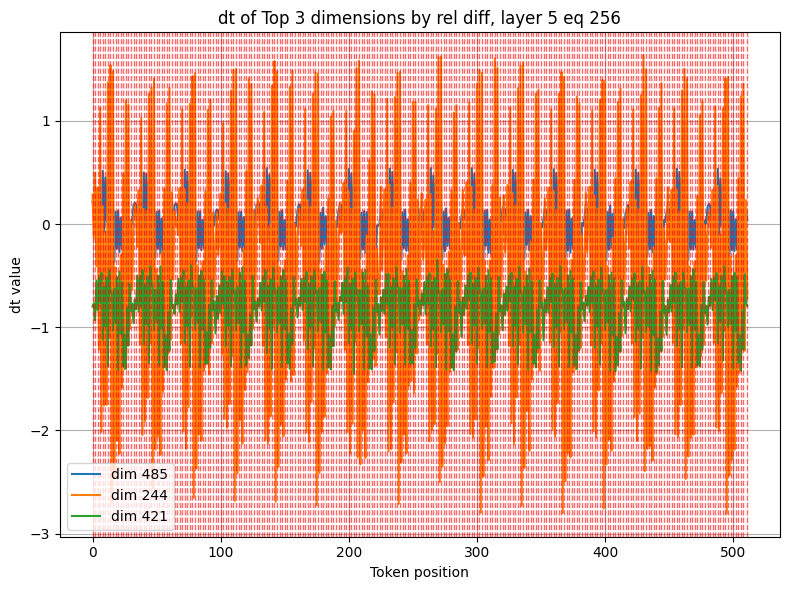

In [121]:
import torch
import matplotlib.pyplot as plt

for j in range(6):
    # Ensure dt_f is detached and on CPU
    dt_f = dts[j, 0, 0]
    dt_f = dt_f.detach().cpu()
    dt = dt_f  # shape (D, L)
    
    # Define x and its inverse (~x)
    x = insert_idxs        # selected token indices
    L = dt.shape[1]
    mask = torch.ones(L, dtype=bool)
    mask[x] = False        # inverse indices: ~x
    
    # Compute per-dimension means over selected and unselected tokens
    mean_selected = dt[:, x].mean(dim=1)               # shape (D,)
    mean_unselected = dt[:, mask].mean(dim=1)          # shape (D,)
    abs_diff = (mean_selected - mean_unselected).abs() # shape (D,)
    
    # Compute std dev for each dimension across all positions
    std_dev = dt.std(dim=1)                            # shape (D,)
    
    # Avoid divide-by-zero
    std_dev[std_dev == 0] = 1e-6
    
    # Compute score = abs_diff / std_dev
    score = abs_diff / std_dev
    
    # Get top 10 dimensions with highest score
    k = 3
    topk = torch.topk(score, k=k)
    topk_indices = topk.indices
    
    # Plot only the top 10 dimensions
    plt.figure(figsize=(8, 6))
    for i in topk_indices:
        plt.plot(dt[i].T, label=f'dim {i.item()}')
        print(f"dim {i.item():2d}: score = {score[i].item():.4f}, abs_diff = {abs_diff[i].item():.4f}, std_dev = {std_dev[i].item():.4f}")
    
    # Plot vertical lines at insert_idxs
    print(insert_idxs.shape)
    for idx in insert_idxs:
        plt.axvline(x=idx.item(), color='red', linestyle='--', linewidth=1, alpha=0.6)
    
    plt.xlabel('Token position')
    plt.ylabel('dt value')
    #plt.xlim(0, L//10)
    plt.title(f'dt of Top {k} dimensions by rel diff, layer {j} eq 256')
    plt.legend()
    #plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    #plt.savefig(f'./figs/dt_layer{j}_middle_64.png')
    plt.show()


dim  6: score = 1.8792, abs_diff = 0.8033, std_dev = 0.4275
dim  4: score = 1.8608, abs_diff = 1.6379, std_dev = 0.8802
dim 14: score = 1.7923, abs_diff = 1.2005, std_dev = 0.6698
dim 15: score = 1.7427, abs_diff = 0.6508, std_dev = 0.3734
dim  3: score = 1.7325, abs_diff = 0.8764, std_dev = 0.5058
dim  0: score = 1.7257, abs_diff = 0.5687, std_dev = 0.3295
dim 11: score = 1.6780, abs_diff = 0.5941, std_dev = 0.3540
dim  7: score = 1.6628, abs_diff = 0.9917, std_dev = 0.5964
dim  8: score = 1.6563, abs_diff = 0.4114, std_dev = 0.2484
dim  5: score = 1.3594, abs_diff = 0.3291, std_dev = 0.2421
dim  1: score = 1.1722, abs_diff = 0.3650, std_dev = 0.3114
dim  2: score = 1.1582, abs_diff = 0.2704, std_dev = 0.2335
dim 12: score = 1.0831, abs_diff = 0.3307, std_dev = 0.3054
dim 10: score = 0.6365, abs_diff = 0.3208, std_dev = 0.5041
dim 13: score = 0.4364, abs_diff = 0.0655, std_dev = 0.1500
dim  9: score = 0.0199, abs_diff = 0.0066, std_dev = 0.3317
torch.Size([256])


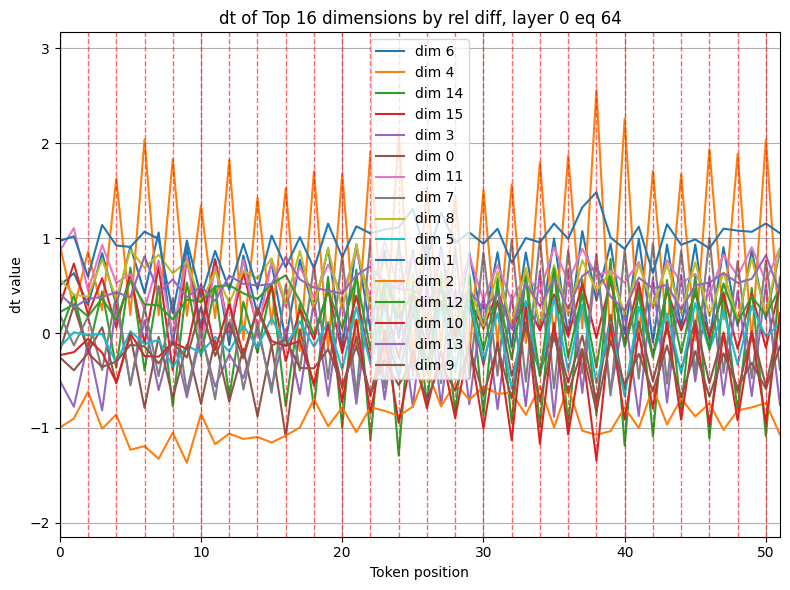

dim  0: score = 1.8118, abs_diff = 1.4498, std_dev = 0.8002
dim 14: score = 1.8104, abs_diff = 1.5017, std_dev = 0.8295
dim  5: score = 1.5947, abs_diff = 0.5055, std_dev = 0.3170
dim  3: score = 1.5923, abs_diff = 0.7941, std_dev = 0.4987
dim  8: score = 1.4173, abs_diff = 0.7696, std_dev = 0.5430
dim 11: score = 1.4137, abs_diff = 0.6590, std_dev = 0.4661
dim  4: score = 1.3255, abs_diff = 0.4900, std_dev = 0.3697
dim  7: score = 1.3116, abs_diff = 0.4151, std_dev = 0.3165
dim  9: score = 1.2457, abs_diff = 0.4816, std_dev = 0.3866
dim  6: score = 1.0132, abs_diff = 0.3595, std_dev = 0.3548
dim  2: score = 0.9427, abs_diff = 0.3398, std_dev = 0.3605
dim  1: score = 0.8588, abs_diff = 0.2470, std_dev = 0.2877
dim 15: score = 0.5813, abs_diff = 0.1618, std_dev = 0.2784
dim 12: score = 0.3029, abs_diff = 0.1132, std_dev = 0.3736
dim 13: score = 0.2805, abs_diff = 0.1266, std_dev = 0.4513
dim 10: score = 0.0628, abs_diff = 0.0242, std_dev = 0.3850
torch.Size([256])


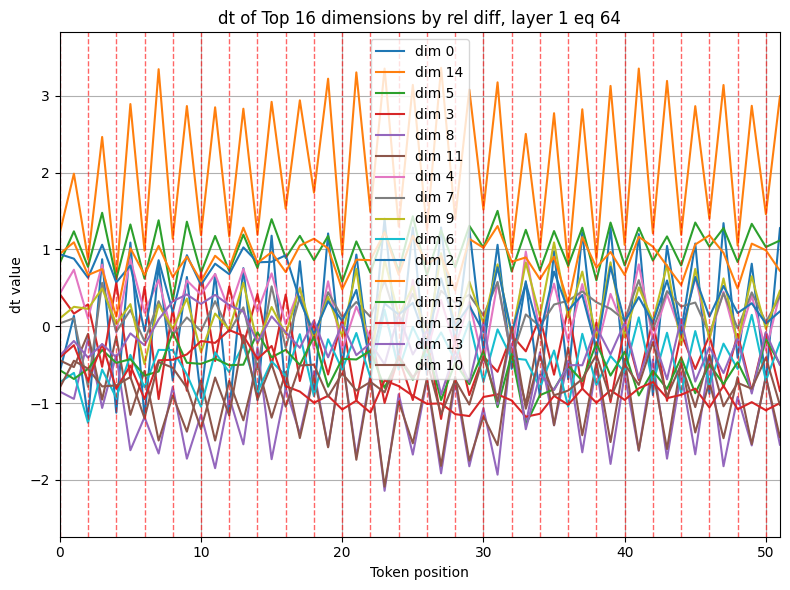

dim 14: score = 1.7814, abs_diff = 1.1317, std_dev = 0.6353
dim  5: score = 1.6588, abs_diff = 0.8501, std_dev = 0.5125
dim  7: score = 1.4822, abs_diff = 0.8608, std_dev = 0.5808
dim  3: score = 1.3757, abs_diff = 0.6571, std_dev = 0.4777
dim 11: score = 1.3737, abs_diff = 0.5393, std_dev = 0.3926
dim  6: score = 1.2882, abs_diff = 0.6674, std_dev = 0.5181
dim  9: score = 1.2563, abs_diff = 0.4177, std_dev = 0.3325
dim 15: score = 1.1664, abs_diff = 0.2640, std_dev = 0.2263
dim  4: score = 0.9143, abs_diff = 0.4320, std_dev = 0.4724
dim  1: score = 0.6388, abs_diff = 0.2098, std_dev = 0.3285
dim  0: score = 0.4071, abs_diff = 0.0967, std_dev = 0.2374
dim 10: score = 0.3526, abs_diff = 0.1002, std_dev = 0.2843
dim 13: score = 0.2874, abs_diff = 0.0968, std_dev = 0.3369
dim  8: score = 0.2308, abs_diff = 0.0819, std_dev = 0.3546
dim 12: score = 0.0778, abs_diff = 0.0203, std_dev = 0.2606
dim  2: score = 0.0411, abs_diff = 0.0119, std_dev = 0.2896
torch.Size([256])


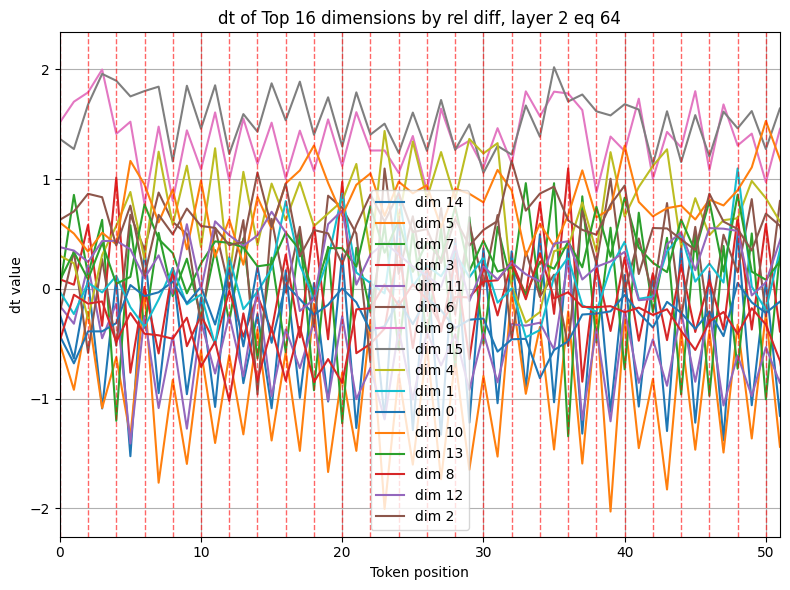

dim  0: score = 1.8017, abs_diff = 1.0336, std_dev = 0.5737
dim  2: score = 1.6306, abs_diff = 0.7467, std_dev = 0.4579
dim 13: score = 1.5720, abs_diff = 0.8637, std_dev = 0.5494
dim 14: score = 1.5469, abs_diff = 0.5293, std_dev = 0.3421
dim  6: score = 1.2702, abs_diff = 0.3672, std_dev = 0.2891
dim  1: score = 1.2255, abs_diff = 0.4944, std_dev = 0.4034
dim  8: score = 1.1676, abs_diff = 0.5047, std_dev = 0.4322
dim  7: score = 1.1329, abs_diff = 0.4348, std_dev = 0.3838
dim  9: score = 1.0291, abs_diff = 0.2868, std_dev = 0.2787
dim 10: score = 0.9947, abs_diff = 0.2900, std_dev = 0.2916
dim  3: score = 0.9838, abs_diff = 0.3353, std_dev = 0.3408
dim  4: score = 0.8952, abs_diff = 0.2770, std_dev = 0.3095
dim 12: score = 0.7900, abs_diff = 0.2102, std_dev = 0.2661
dim  5: score = 0.4538, abs_diff = 0.1444, std_dev = 0.3182
dim 15: score = 0.1466, abs_diff = 0.0359, std_dev = 0.2452
dim 11: score = 0.0835, abs_diff = 0.0305, std_dev = 0.3653
torch.Size([256])


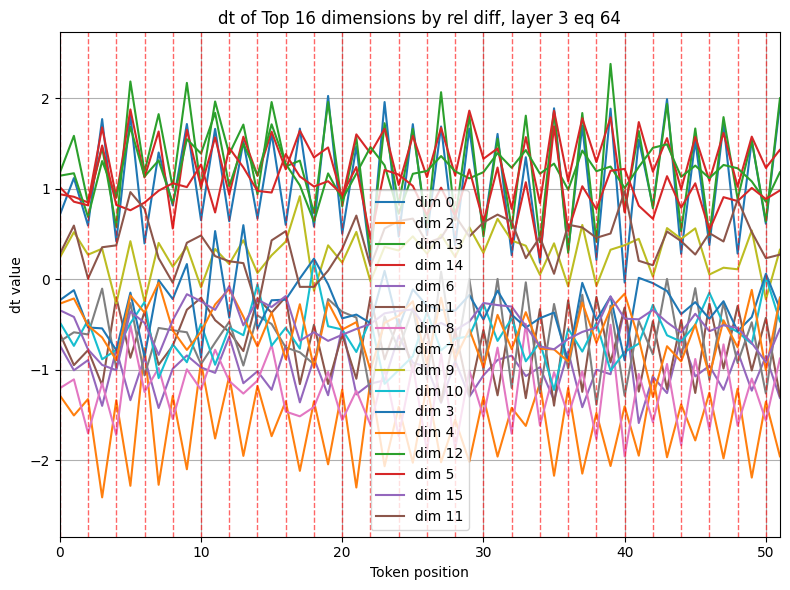

dim 11: score = 1.2196, abs_diff = 1.3955, std_dev = 1.1442
dim 15: score = 1.0389, abs_diff = 0.6125, std_dev = 0.5896
dim  7: score = 0.9759, abs_diff = 1.2072, std_dev = 1.2370
dim  3: score = 0.8684, abs_diff = 0.6217, std_dev = 0.7158
dim  6: score = 0.7191, abs_diff = 0.6982, std_dev = 0.9709
dim 10: score = 0.6002, abs_diff = 0.4156, std_dev = 0.6925
dim  8: score = 0.5707, abs_diff = 0.5382, std_dev = 0.9431
dim 14: score = 0.4645, abs_diff = 0.5639, std_dev = 1.2140
dim  4: score = 0.4002, abs_diff = 0.5498, std_dev = 1.3737
dim  0: score = 0.3907, abs_diff = 0.3566, std_dev = 0.9128
dim  5: score = 0.3828, abs_diff = 0.6889, std_dev = 1.7998
dim  1: score = 0.3019, abs_diff = 0.4125, std_dev = 1.3665
dim  9: score = 0.2410, abs_diff = 0.2076, std_dev = 0.8615
dim 12: score = 0.1223, abs_diff = 0.1715, std_dev = 1.4021
dim  2: score = 0.0312, abs_diff = 0.0257, std_dev = 0.8233
dim 13: score = 0.0273, abs_diff = 0.0327, std_dev = 1.1998
torch.Size([256])


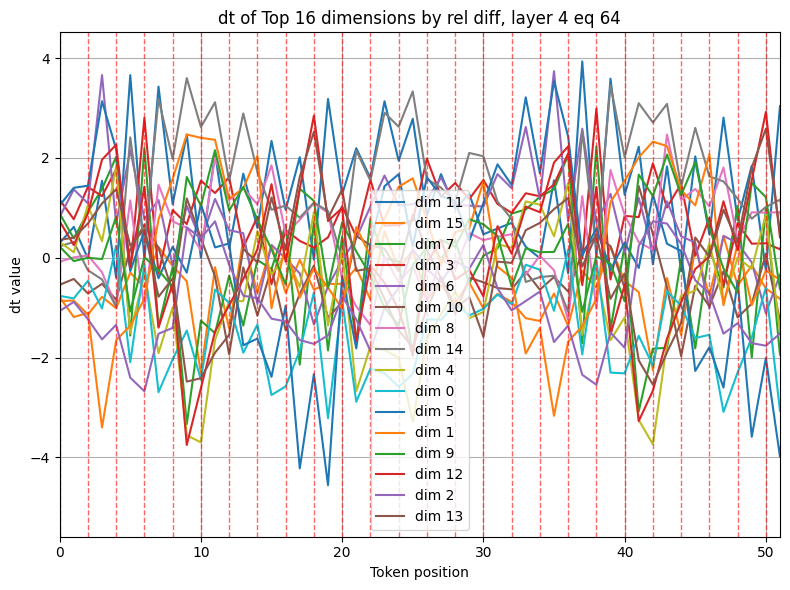

dim  5: score = 0.6015, abs_diff = 0.8752, std_dev = 1.4551
dim 14: score = 0.5716, abs_diff = 0.7515, std_dev = 1.3146
dim  9: score = 0.4377, abs_diff = 0.5263, std_dev = 1.2024
dim  1: score = 0.4273, abs_diff = 0.3576, std_dev = 0.8370
dim  6: score = 0.3183, abs_diff = 0.3582, std_dev = 1.1254
dim 15: score = 0.3148, abs_diff = 0.3989, std_dev = 1.2674
dim 12: score = 0.2910, abs_diff = 0.4113, std_dev = 1.4135
dim 11: score = 0.2887, abs_diff = 0.2398, std_dev = 0.8308
dim  4: score = 0.2599, abs_diff = 0.4008, std_dev = 1.5420
dim  3: score = 0.2469, abs_diff = 0.2116, std_dev = 0.8572
dim 10: score = 0.1689, abs_diff = 0.0970, std_dev = 0.5739
dim 13: score = 0.1488, abs_diff = 0.1463, std_dev = 0.9837
dim  0: score = 0.1063, abs_diff = 0.1118, std_dev = 1.0517
dim  8: score = 0.0581, abs_diff = 0.0448, std_dev = 0.7714
dim  2: score = 0.0344, abs_diff = 0.0357, std_dev = 1.0364
dim  7: score = 0.0190, abs_diff = 0.0177, std_dev = 0.9333
torch.Size([256])


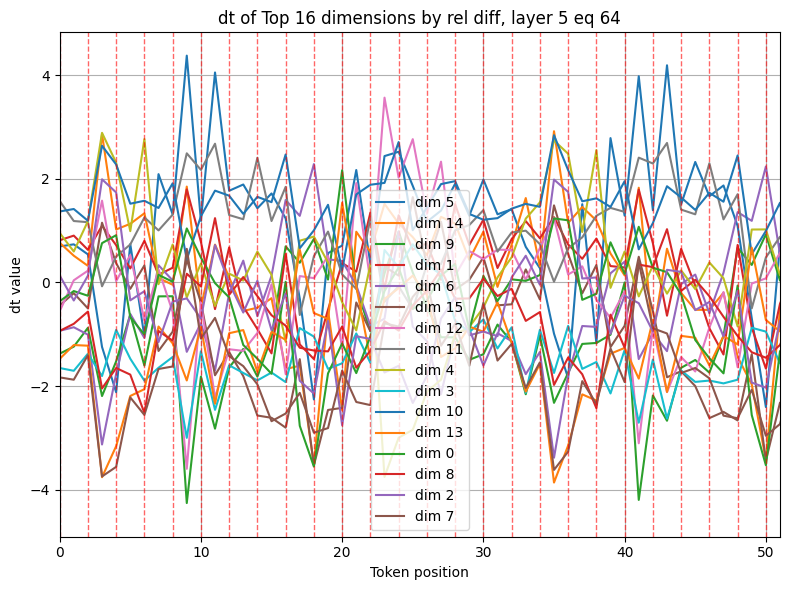

In [19]:
import torch
import matplotlib.pyplot as plt

for j in range(6):
    # Ensure dt_f is detached and on CPU
    dt_f = dts_lr[j, 0, 0]
    dt_f = dt_f.detach().cpu()
    dt = dt_f  # shape (D, L)
    
    # Define x and its inverse (~x)
    x = insert_idxs        # selected token indices
    L = dt.shape[1]
    mask = torch.ones(L, dtype=bool)
    mask[x] = False        # inverse indices: ~x
    
    # Compute per-dimension means over selected and unselected tokens
    mean_selected = dt[:, x].mean(dim=1)               # shape (D,)
    mean_unselected = dt[:, mask].mean(dim=1)          # shape (D,)
    abs_diff = (mean_selected - mean_unselected).abs() # shape (D,)
    
    # Compute std dev for each dimension across all positions
    std_dev = dt.std(dim=1)                            # shape (D,)
    
    # Avoid divide-by-zero
    std_dev[std_dev == 0] = 1e-6
    
    # Compute score = abs_diff / std_dev
    score = abs_diff / std_dev
    
    # Get top 10 dimensions with highest score
    k = 16
    topk = torch.topk(score, k=k)
    topk_indices = topk.indices
    
    # Plot only the top 10 dimensions
    plt.figure(figsize=(8, 6))
    for i in topk_indices:
        plt.plot(dt[i].T, label=f'dim {i.item()}')
        print(f"dim {i.item():2d}: score = {score[i].item():.4f}, abs_diff = {abs_diff[i].item():.4f}, std_dev = {std_dev[i].item():.4f}")
    
    # Plot vertical lines at insert_idxs
    print(insert_idxs.shape)
    for idx in insert_idxs:
        plt.axvline(x=idx.item(), color='red', linestyle='--', linewidth=1, alpha=0.6)
    
    plt.xlabel('Token position')
    plt.ylabel('dt value')
    plt.xlim(0, L//10)
    plt.title(f'dt of Top {k} dimensions by rel diff, layer {j} eq 64')
    plt.legend()
    #plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f'./figs/dt_layer{j}_middle_64.png')
    plt.show()


In [13]:
import torch
import matplotlib.pyplot as plt

for j in range(6):
    # Ensure dt_f is detached and on CPU
    dt_f = dts_lr[j, 0, 0]
    dt_f = dt_f.detach().cpu()
    dt = dt_f  # shape (D, L)
    print(dt.shape)
    
    # Define x and its inverse (~x)
    x = insert_idxs        # selected token indices
    L = dt.shape[1]
    mask = torch.ones(L, dtype=bool)
    mask[x] = False        # inverse indices: ~x
    
    # Compute per-dimension means over selected and unselected tokens
    mean_selected = dt[:, x].mean(dim=1)               # shape (D,)
    mean_unselected = dt[:, mask].mean(dim=1)          # shape (D,)
    abs_diff = (mean_selected - mean_unselected).abs() # shape (D,)
    
    # Compute std dev for each dimension across all positions
    std_dev = dt.std(dim=1)                            # shape (D,)
    
    # Avoid divide-by-zero
    std_dev[std_dev == 0] = 1e-6
    
    # Compute score = abs_diff / std_dev
    score = abs_diff / std_dev
    
    # Get top 10 dimensions with highest score
    k = 2
    topk = torch.topk(score, k=k)
    topk_indices = topk.indices
    
    # Plot only the top 10 dimensions
    plt.figure(figsize=(8, 6))
    for i in topk_indices:
        plt.plot(dt[i].T, label=f'dim {i.item()}')
        print(f"dim {i.item():2d}: score = {score[i].item():.4f}, abs_diff = {abs_diff[i].item():.4f}, std_dev = {std_dev[i].item():.4f}")
    
    # Plot vertical lines at insert_idxs
    print(insert_idxs.shape)
    for idx in insert_idxs:
        plt.axvline(x=idx.item(), color='red', linestyle='--', linewidth=1, alpha=0.6)
    
    plt.xlabel('Token position')
    plt.ylabel('dt value')
    plt.xlim(0, L//10)
    plt.title(f'dt of Top {k} dimensions by rel diff, layer {j} eq 64')
    plt.legend()
    #plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f'./figs/dt_layer{j}_middle_64.png')
    plt.show()


TypeError: list indices must be integers or slices, not tuple

In [ ]:
# Visualize
test_loader = DataLoader(
    test_dataset,
    batch_size=cfg['test_dataset']['loader']['batch_size'],
    num_workers=cfg['test_dataset']['loader']['num_workers'],
    shuffle=False,
    pin_memory=True
)
visualize_results(model, test_loader, device, n_samples=6, out_dir=f'./eval_vis/{cfg_string}')

In [25]:
import os
import re

log_name = "lp_study"
log_root = f"./save/{log_name}"  # folder containing subfolders f
output_file = "best_psnrs.txt"
results = []

# Regex to extract eval PSNR from a line
psnr_pattern = re.compile(r"eval: loss=[\d\.]+ psnr=([\d\.]+)")

# Iterate through each subfolder in l/
for folder in os.listdir(log_root):
    subdir = os.path.join(log_root, folder)
    log_path = os.path.join(subdir, "log.txt")

    if not os.path.isfile(log_path):
        continue  # skip if no log.txt

    best_psnr = float('-inf')
    try:
        with open(log_path, "r") as f:
            for line in f:
                match = psnr_pattern.search(line)
                if match:
                    psnr = float(match.group(1))
                    best_psnr = max(best_psnr, psnr)
    except Exception as e:
        print(f"Error reading {log_path}: {e}")
        continue

    if best_psnr > float('-inf'):
        results.append((folder, best_psnr))

# Sort by PSNR descending
results.sort(key=lambda x: x[1], reverse=True)

# Write to output file
with open(output_file, "w") as f_out:
    for folder, psnr in results:
        line = f"{folder}: {psnr:.4f}"
        print(line)
        f_out.write(line + "\n")


imgrec_cifar10_mamba_composers_ngroup2: 55.3324
imgrec_cifar10_mamba_composers_l{0}_128: 55.1072
imgrec_cifar10_mamba_composers_l{0}_192: 55.0362
imgrec_cifar10_mamba_composers_l{0}_256: 54.9180
imgrec_cifar10_mamba_composers_ngroup16: 54.7165
imgrec_cifar10_mamba_composers_l{0}_64: 54.5152
imgrec_cifar10_mamba_composers_ngroup32_256: 54.3141
imgrec_cifar10_mamba_composers_ngroup16_192: 54.1459
imgrec_cifar10_mamba_composers_ngroup2_128: 54.1363
imgrec_cifar10_mamba_composers_ngroup32_192: 53.9813
imgrec_cifar10_mamba_composers_ngroup16_128: 53.7720
imgrec_cifar10_mamba_composers_ngroup2_64: 53.6250
imgrec_cifar10_mamba_composers_ngroup32_128: 52.0744
imgrec_cifar10_mamba_composers_ngroup16_64: 51.8520
imgrec_cifar10_mamba_composers_ngroup64: 51.3820
imgrec_cifar10_mamba_composers_middle: 51.2841
imgrec_cifar10_mamba_composers_middle_192: 49.9193
imgrec_cifar10_mamba_composers_middle_64: 48.7417
imgrec_cifar10_mamba_composers_middle_128: 48.4593
imgrec_cifar10_mamba_composers_ngroup32_

In [ ]:
import os
from tensorboard.backend.event_processing import event_accumulator
import matplotlib.pyplot as plt

# Path to your TensorBoard run directory (e.g., './runs/Jul13_13-21-57_my_run')
run_name = 'imgrec_celeba_mamba_lainr_fourier_long_constant_resume'
log_dir = f'./save/{run_name}/tensorboard'

# Load the TensorBoard event file
ea = event_accumulator.EventAccumulator(log_dir,
    size_guidance={  # Load scalars, histograms, etc.
        event_accumulator.SCALARS: 0,
    })
ea.Reload()

# List available scalar tags
print("Available scalar tags:", ea.Tags()['scalars'])

# Change these if your tags are named differently
train_loss_tag = 'train/loss'
eval_loss_tag = 'test/loss'
train_psnr_tag = 'train/psnr'
eval_psnr_tag = 'test/psnr'

# Extract data for each tag
train_events = ea.Scalars(train_loss_tag)
eval_events = ea.Scalars(eval_loss_tag)

train_events_psnr = ea.Scalars(train_psnr_tag)
eval_events_psnr = ea.Scalars(eval_psnr_tag)

start_point = 0
# Extract steps and values
train_steps = [e.step for e in train_events][start_point:]
train_values = [e.value for e in train_events][start_point:]

train_steps_psnr = [e.step for e in train_events_psnr][start_point:]
train_values_psnr = [e.value for e in train_events_psnr][start_point:]


eval_steps = [e.step for e in eval_events][start_point:]
eval_values = [e.value for e in eval_events][start_point:]

eval_steps_psnr = [e.step for e in eval_events_psnr][start_point:]
eval_values_psnr = [e.value for e in eval_events_psnr][start_point:]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(train_steps, train_values, label='Train Loss', marker='o')
plt.plot(eval_steps, eval_values, label='Eval Loss', marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
#plt.ylim(0, 0.0002)
plt.title('Training and Evaluation Loss from TensorBoard Logs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


plt.figure(figsize=(6, 6))
plt.plot(train_steps_psnr, train_values_psnr, label='Train PSNR', marker='o')
plt.plot(eval_steps_psnr, eval_values_psnr, label='Eval PSNR', marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
#plt.ylim(0, 0.0002)
plt.title('Mamba Composers CIFAR-10 Long')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Available scalar tags: ['lr', 'train/loss', 'train/psnr', 'test/loss', 'test/psnr']


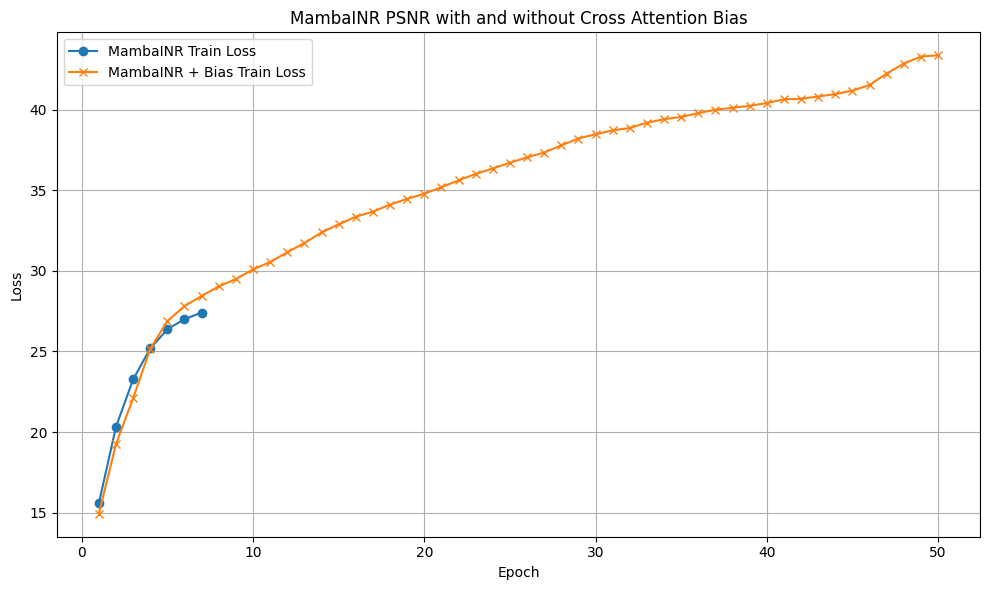

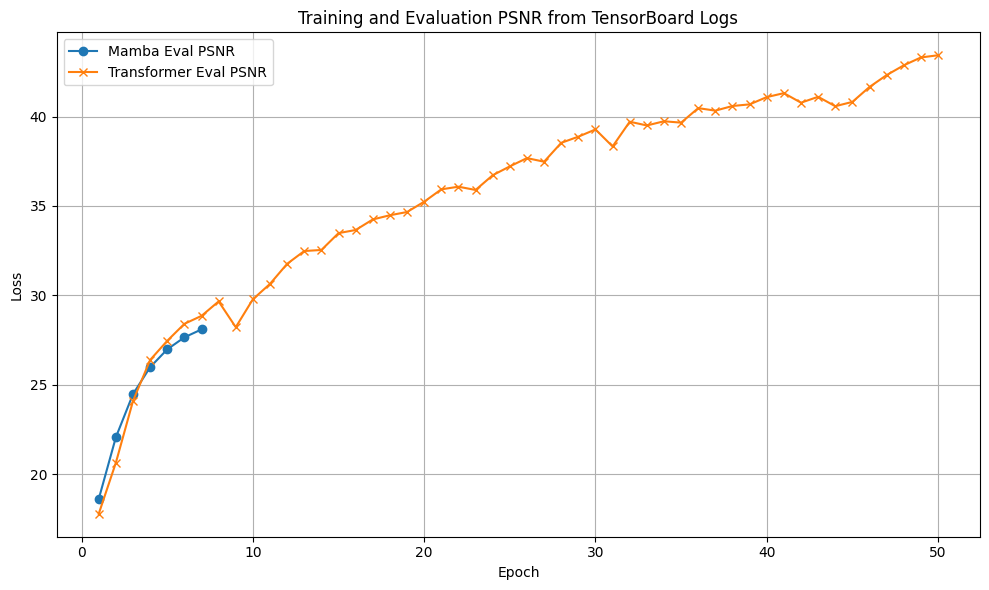

In [48]:
import os
from tensorboard.backend.event_processing import event_accumulator
import matplotlib.pyplot as plt

# Path to your TensorBoard run directory (e.g., './runs/Jul13_13-21-57_my_run')
run_name = 'imgrec_celeba_mamba_lainr_fourier_sr_noperturbation_gff_20'
#run_name = 'imgrec_celeba_mamba_lainr_fourier_sr_allon'
#run_name2 = 'imgrec_cifar10_mamba_lainr_fourier_long_fast'
run_name2 = 'imgrec_celeba_mamba_lainr_fourier_sr_noperturbation'

#run_name = 'imgrec_cifar10_mamba_lainr_fourier_const'
#run_name2 = 'imgrec_cifar10_lainr_fourier_const'

log_dir = f'./save/{run_name}/tensorboard'
log_dir2 = f'./save/{run_name2}/tensorboard'

# Load the TensorBoard event file
ea = event_accumulator.EventAccumulator(log_dir,
    size_guidance={  # Load scalars, histograms, etc.
        event_accumulator.SCALARS: 0,
    })

ea2 = event_accumulator.EventAccumulator(log_dir2,
    size_guidance={  # Load scalars, histograms, etc.
        event_accumulator.SCALARS: 0,
    })

ea.Reload()
ea2.Reload()

# List available scalar tags
print("Available scalar tags:", ea.Tags()['scalars'])

# Change these if your tags are named differently
train_loss_tag = 'train/psnr'
eval_loss_tag = 'train/psnr'
train_psnr_tag = 'train/psnr'
eval_psnr_tag = 'test/psnr'

# Extract data for each tag
train_events = ea.Scalars(eval_loss_tag)
eval_events = ea2.Scalars(eval_loss_tag)

train_events_psnr = ea.Scalars(eval_psnr_tag)
eval_events_psnr = ea2.Scalars(eval_psnr_tag)

start_point = 0
# Extract steps and values
train_steps = [e.step for e in train_events][start_point:]
train_values = [e.value for e in train_events][start_point:]

train_steps_psnr = [e.step for e in train_events_psnr][start_point:]
train_values_psnr = [e.value for e in train_events_psnr][start_point:]


eval_steps = [e.step for e in eval_events][start_point:]
eval_values = [e.value for e in eval_events][start_point:]

eval_steps_psnr = [e.step for e in eval_events_psnr][start_point:]
eval_values_psnr = [e.value for e in eval_events_psnr][start_point:]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(train_steps, train_values, label='MambaINR Train Loss', marker='o')
plt.plot(eval_steps, eval_values, label='MambaINR + Bias Train Loss', marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
#plt.ylim(0, 0.0002)
plt.title('MambaINR PSNR with and without Cross Attention Bias')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


plt.figure(figsize=(10, 6))
plt.plot(train_steps_psnr, train_values_psnr, label='Mamba Eval PSNR', marker='o')
plt.plot(eval_steps_psnr, eval_values_psnr, label='Transformer Eval PSNR', marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
#plt.ylim(0, 0.0002)
plt.title('Training and Evaluation PSNR from TensorBoard Logs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


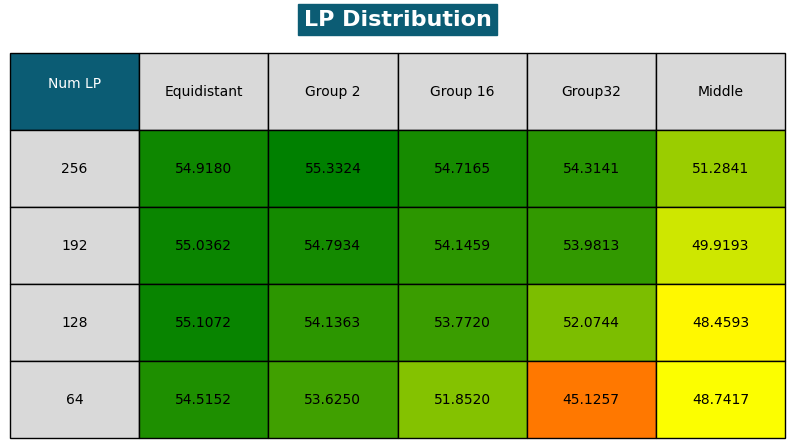

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.table import Table
from matplotlib.colors import LinearSegmentedColormap

# Define data and labels
row_labels = ['256', '192', '128', '64']
col_labels = ['Equidistant', 'Group 2', 'Group 16', 'Group32', 'Middle']

data = np.array([
    [54.9180, 55.3324, 54.7165, 54.3141, 51.2841],
    [55.0362, 54.7934, 54.1459, 53.9813, 49.9193],
    [55.1072, 54.1363, 53.7720, 52.0744, 48.4593],
    [54.5152, 53.6250, 51.8520, 45.1257, 48.7417]
])

# Normalize for color mapping
vmin = 42
vmax = data.max()
norm = plt.Normalize(vmin, vmax)

# Green → Yellow → Red colormap
cmap = LinearSegmentedColormap.from_list("value_cmap", ["red", "yellow", "green"])

# Plot setup
fig, ax = plt.subplots(figsize=(10, 5))
ax.set_axis_off()

table = Table(ax, bbox=[0, 0, 1, 1])

n_rows, n_cols = data.shape
width, height = 1.0 / (n_cols + 1), 1.0 / (n_rows + 1)

# Add data cells with individual background colors based on value
for i in range(n_rows):
    for j in range(n_cols):
        val = data[i, j]
        bgcolor = cmap(norm(val))  # use value to get color
        cell = table.add_cell(i + 1, j + 1, width, height, text=f"{val:.4f}", loc='center',
                              facecolor=bgcolor, edgecolor='black')
        cell.set_linewidth(1)

# Row labels
for i, label in enumerate(row_labels):
    table.add_cell(i + 1, 0, width, height, text=label, loc='center',
                   facecolor='#d9d9d9', edgecolor='black')

# Column labels
for j, label in enumerate(col_labels):
    table.add_cell(0, j + 1, width, height, text=label, loc='center',
                   facecolor='#d9d9d9', edgecolor='black')

# Top-left corner cell
cell = table.add_cell(0, 0, width, height, text='Num LP\n', loc='center', facecolor='#0b5c74', edgecolor='black')
cell.get_text().set_color('white')

# Add table to plot
ax.add_table(table)

# Title
ax.set_title("LP Distribution", fontsize=16, fontweight='bold', color='white',
             backgroundcolor='#0b5c74', pad=20)

plt.show()


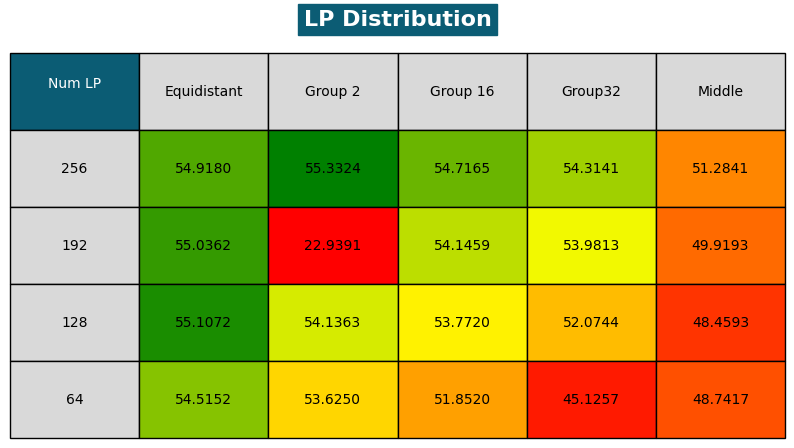

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.table import Table
from matplotlib.colors import LinearSegmentedColormap

# Define data and labels
row_labels = ['256', '192', '128', '64']
col_labels = ['Equidistant', 'Group 2', 'Group 16', 'Group32', 'Middle']

data = np.array([
    [54.9180, 55.3324, 54.7165, 54.3141, 51.2841],
    [55.0362, 22.9391, 54.1459, 53.9813, 49.9193],
    [55.1072, 54.1363, 53.7720, 52.0744, 48.4593],
    [54.5152, 53.6250, 51.8520, 45.1257, 48.7417]
])

# Compute ranks (0 = lowest, 19 = highest)
flat = data.flatten()
ranks = flat.argsort().argsort()  # rank index: shape (20,)
ranks = ranks.reshape(data.shape)
rank_norm = ranks / ranks.max()  # Normalize to [0, 1]

# Create color map (red → yellow → green)
cmap = LinearSegmentedColormap.from_list("rank_cmap", ["red", "yellow", "green"])

# Plot setup
fig, ax = plt.subplots(figsize=(10, 5))
ax.set_axis_off()

table = Table(ax, bbox=[0, 0, 1, 1])
n_rows, n_cols = data.shape
width, height = 1.0 / (n_cols + 1), 1.0 / (n_rows + 1)

# Add cells with rank-based coloring
for i in range(n_rows):
    for j in range(n_cols):
        val = data[i, j]
        color = cmap(rank_norm[i, j])
        table.add_cell(i + 1, j + 1, width, height, text=f"{val:.4f}", loc='center',
                       facecolor=color, edgecolor='black')

# Add row and column headers
for i, label in enumerate(row_labels):
    table.add_cell(i + 1, 0, width, height, text=label, loc='center',
                   facecolor='#d9d9d9', edgecolor='black')

for j, label in enumerate(col_labels):
    table.add_cell(0, j + 1, width, height, text=label, loc='center',
                   facecolor='#d9d9d9', edgecolor='black')

# Top-left header
cell = table.add_cell(0, 0, width, height, text='Num LP\n', loc='center',
                      facecolor='#0b5c74', edgecolor='black')
cell.get_text().set_color('white')

# Add table to plot
ax.add_table(table)

# Title
ax.set_title("LP Distribution", fontsize=16, fontweight='bold', color='white',
             backgroundcolor='#0b5c74', pad=20)

plt.show()
